Stock prediction model: the goal is to create a predictive algorithim that can predict next days prices using the data from the last week's worth of close prices. Over time I shifted emphasis to accurately being able to predict trends of the market and the direction the stock is expected to go.

In [ ]:
#libraries used
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
import requests
import datetime as dt
import pandas as pd

Data Fetching and variable definition for stock variables


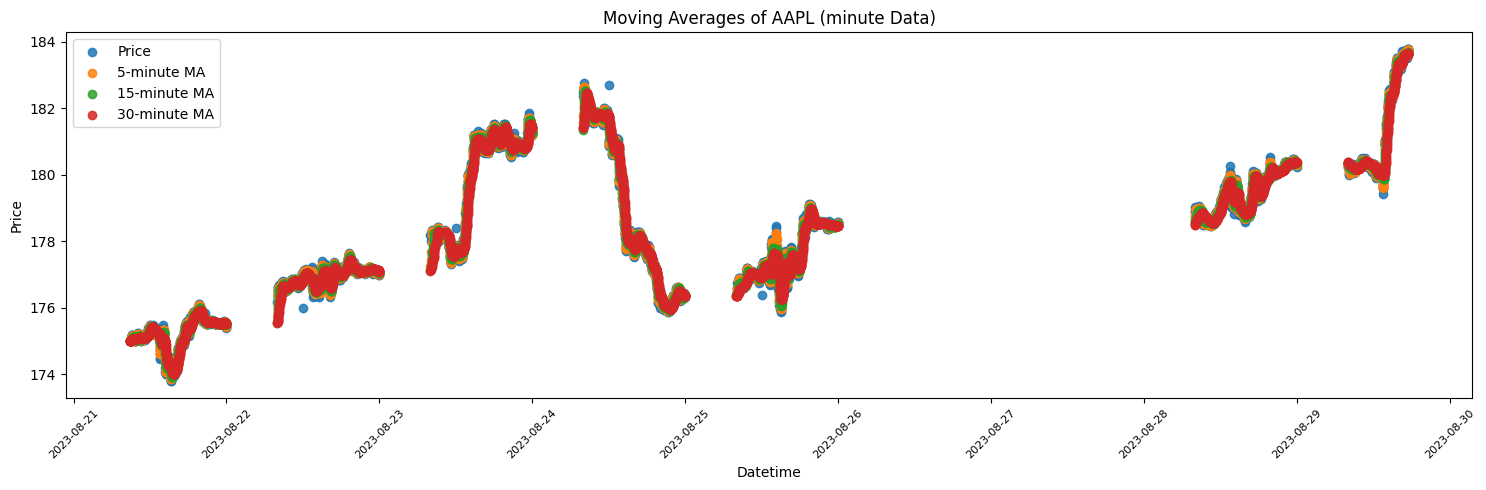

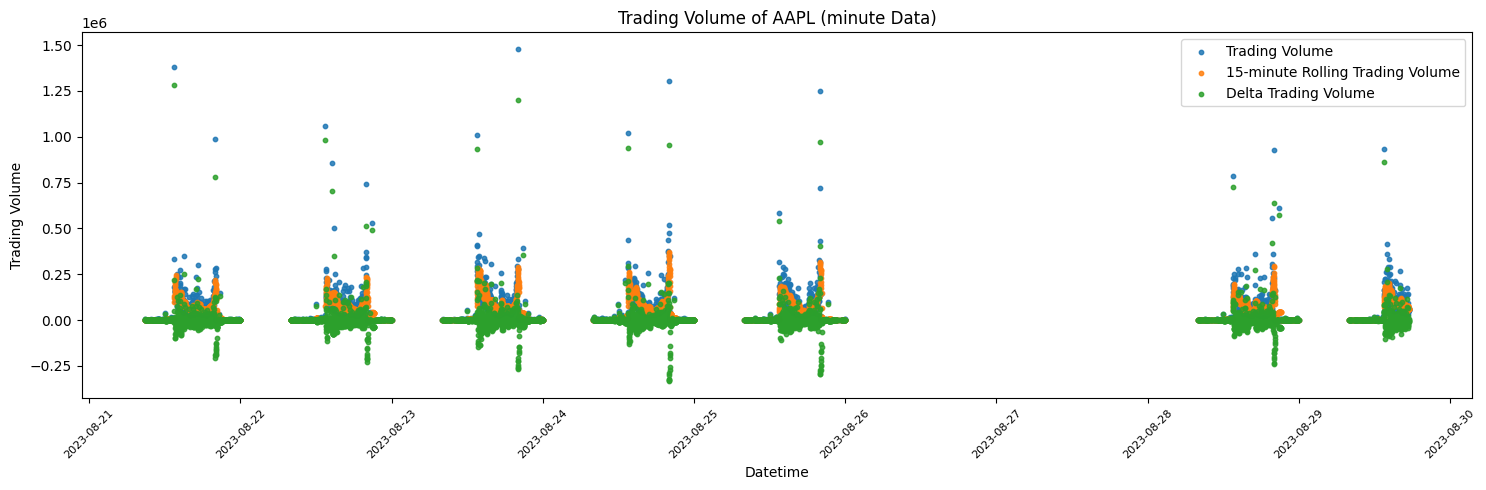

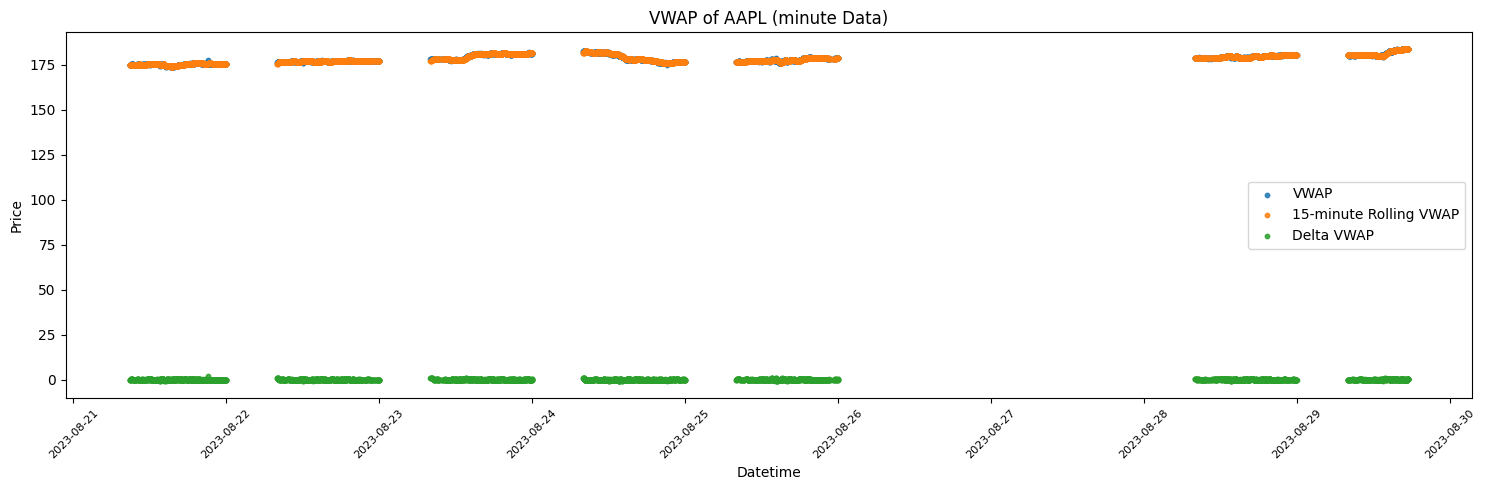

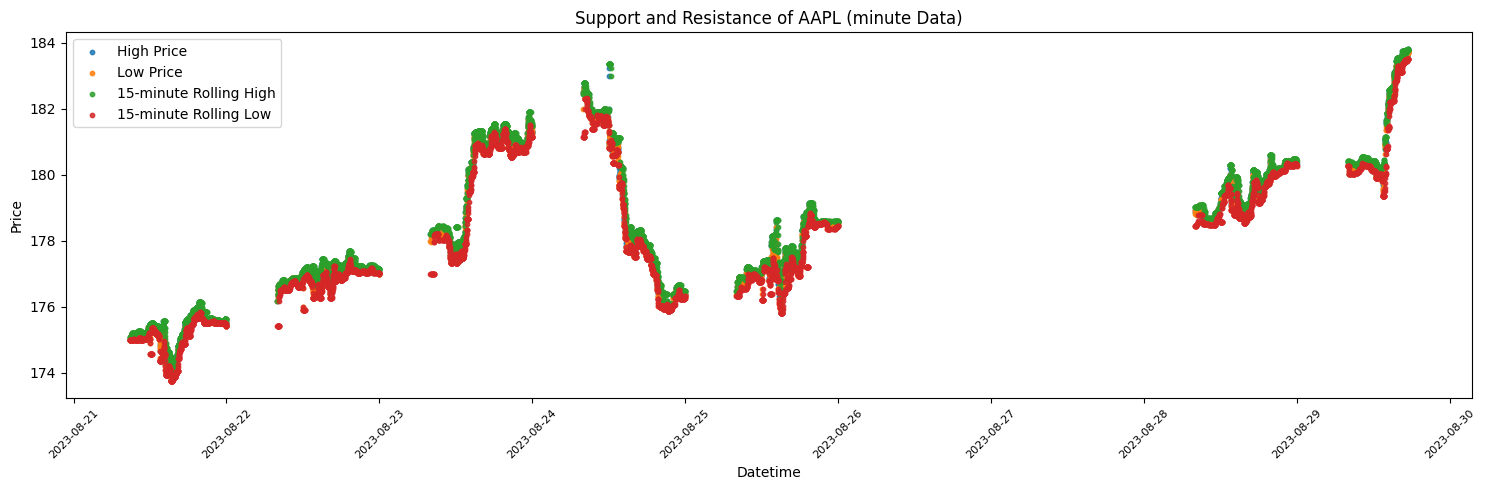

Data for AAPL fetched and processed successfully.


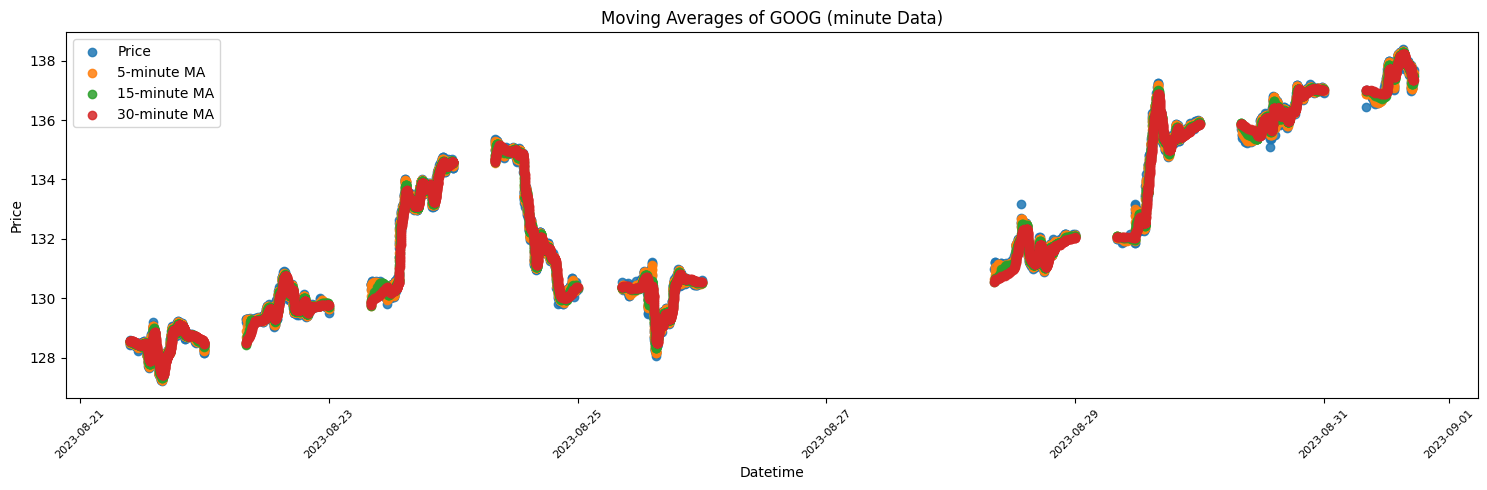

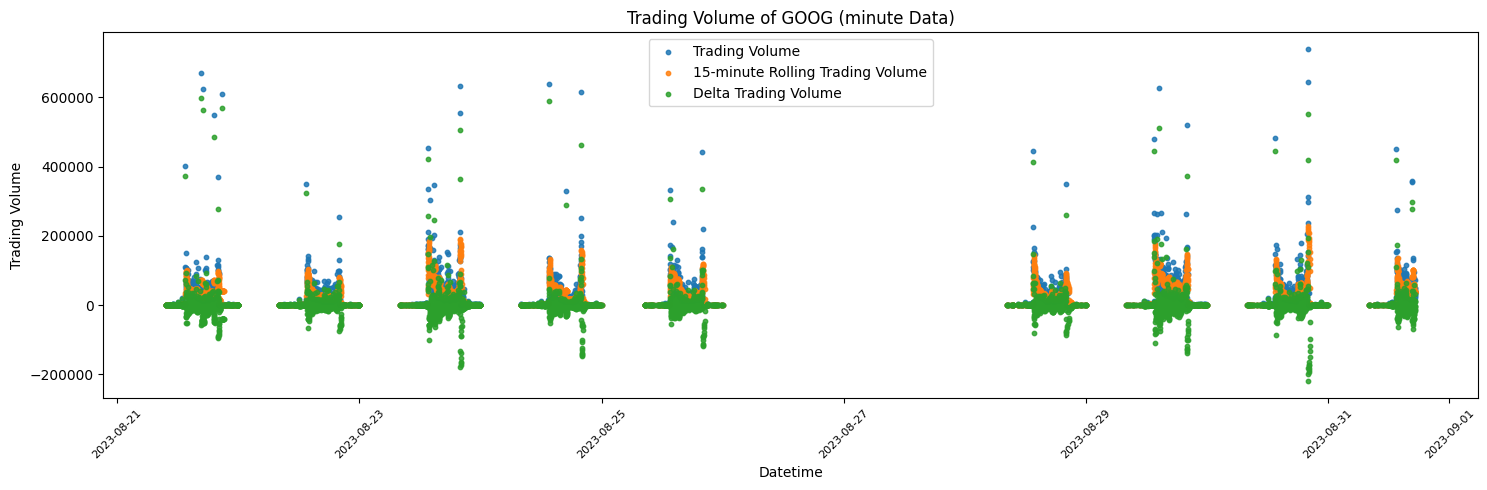

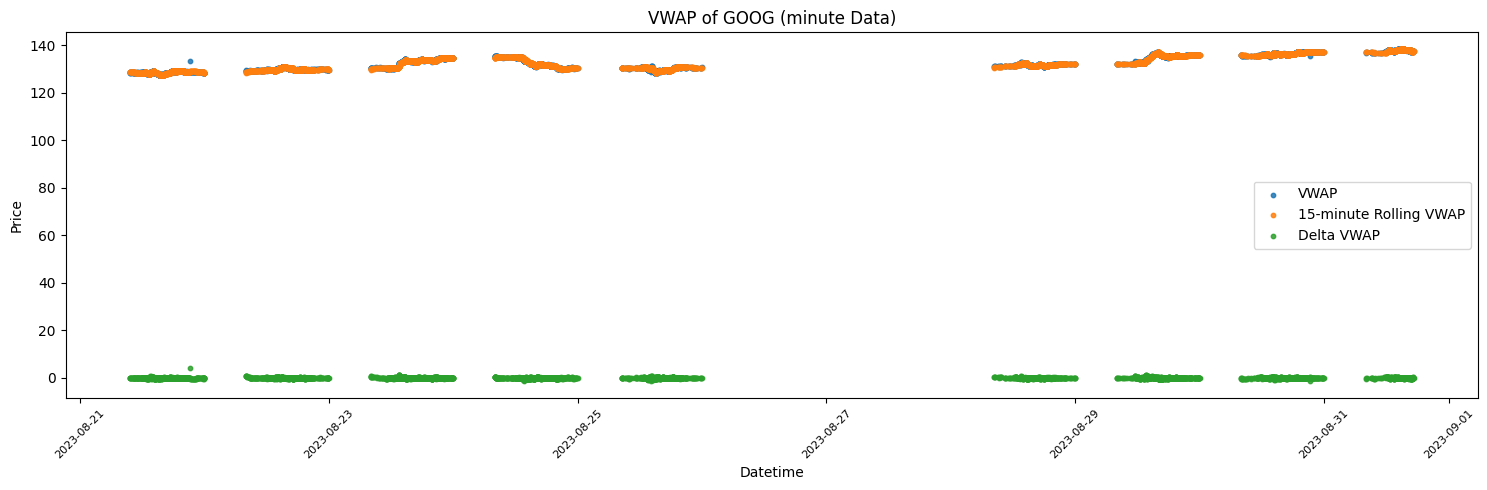

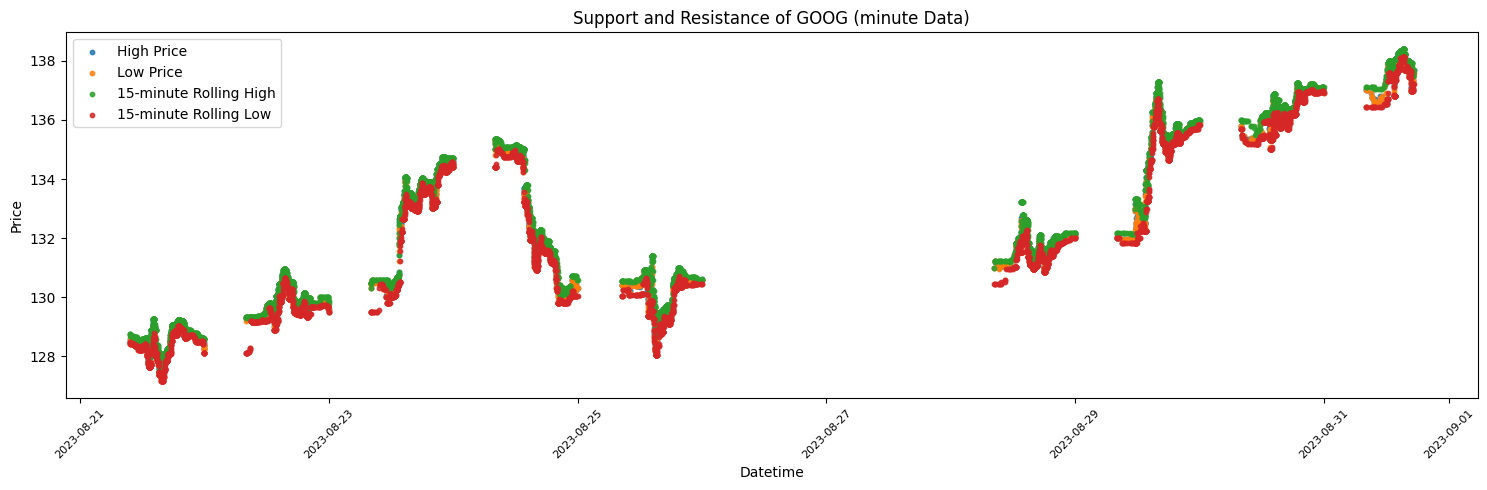

Data for GOOG fetched and processed successfully.
Issue with fetching for TSLA
Issue with fetching for MSFT


In [ ]:
# Data Fetching and variable definition

#api key
key = 'CPbnNd21WpJizO2BdPwD50RPPe3vJlxr'

#Time Range
today = dt.date.today()
start = today - dt.timedelta(days=730)


#call parameters
stock = ['AAPL', 'GOOG', 'TSLA', 'MSFT']
range_val = '1'
timeframe = 'minute'
start = start
end = today

stock_data_dict = {}

#data fetching
for ticker in stock:
  url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{range_val}/{timeframe}/{start}/{end}?apiKey={key}"
  request = requests.get(url)
  if request.status_code == 200 and 'results' in request.json() and request.json()['results']:
      stock_data = request.json()['results']

      #storing and sorting
      data = pd.DataFrame({
          'datetime': pd.to_datetime([entry['t'] for entry in stock_data], unit='ms'),
          'price': [entry['c'] for entry in stock_data],
          'high_price': [entry['h'] for entry in stock_data],
          'low_price': [entry['l'] for entry in stock_data],
          'trading_volume': [entry['v'] for entry in stock_data],
          'vwap': [entry['vw'] for entry in stock_data],
          })


      data.sort_values(by='datetime', inplace=True)
      data.set_index('datetime', inplace=True)

      #previous prices
      data[f'previous_price_1{timeframe}'] = data['price'].shift(1)
      data[f'previous_price_2{timeframe}'] = data['price'].shift(2)
      data[f'previous_price_3{timeframe}'] = data['price'].shift(3)
      data[f'previous_price_4{timeframe}'] = data['price'].shift(4)
      data[f'previous_price_5{timeframe}'] = data['price'].shift(5)


      #support and resistance based on rolling windows
      data['high_low_diff'] = data['high_price'] - data['low_price']
      data[f'rolling_high_15{timeframe}'] = data['high_price'].rolling(window=15).max()
      data[f'rolling_low_15{timeframe}'] = data['low_price'].rolling(window=15).min()


      #trading volume
      data[f'rolling_trading_volume_15{timeframe}'] = data['trading_volume'].rolling(window=15).mean()
      data['delta_trading_volume'] = data['trading_volume'] - data[f'rolling_trading_volume_15{timeframe}']


      #moving averages (adjust window sizes for minutes)
      data[f'MA_5{timeframe}'] = data['price'].rolling(window=5).mean()
      data[f'MA_15{timeframe}'] = data['price'].rolling(window=15).mean()
      data[f'MA_30{timeframe}'] = data['price'].rolling(window=30).mean()


      #volume weighted average
      data[f'rolling_vwap_15{timeframe}'] = data['vwap'].rolling(window=15).mean()
      data[f'rolling_vwap_30{timeframe}'] = data['vwap'].rolling(window=30).mean()
      data['delta_vwap'] = data['vwap'] - data[f'rolling_vwap_15{timeframe}']
      data[f'delta_vwap_30{timeframe}'] = data['vwap'] - data[f'rolling_vwap_30{timeframe}']


      #Relative Strength Index (RSI)
      rsi_period = 7
      delta = data['price'].diff()
      gain = delta.where(delta > 0, 0)
      loss = -delta.where(delta < 0, 0)
      avg_gain = gain.ewm(com=rsi_period - 1, adjust=False).mean()
      avg_loss = loss.ewm(com=rsi_period - 1, adjust=False).mean()
      rs = avg_gain / avg_loss.replace(0, np.nan)
      data['RSI'] = 100 - (100 / (1 + rs))


      # Moving Average Convergence Divergence (MACD)
      ema_short_period = 12
      ema_long_period = 26
      signal_period = 9

      exp12 = data['price'].ewm(span=ema_short_period, adjust=False).mean()
      exp26 = data['price'].ewm(span=ema_long_period, adjust=False).mean()
      data['MACD'] = exp12 - exp26
      data['MACD_Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
      data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']


      # Bollinger Bands
      bb_period = 15
      bb_multiplier = 1.5

      data['BB_Middle'] = data['price'].rolling(window=bb_period).mean()
      data['BB_StdDev'] = data['price'].rolling(window=bb_period).std()
      data['BB_Upper'] = data['BB_Middle'] + (data['BB_StdDev'] * bb_multiplier)
      data['BB_Lower'] = data['BB_Middle'] - (data['BB_StdDev'] * bb_multiplier)


      data.dropna(inplace=True)


      # Store the processed data for the current ticker in the dictionary
      stock_data_dict[ticker] = data

      # graphing moving averages
      plt.figure(figsize=(15, 5))
      plt.scatter(data.index, data['price'], label='Price', alpha=0.85)
      plt.scatter(data.index, data[f'MA_5{timeframe}'], label=f'5-{timeframe} MA', alpha=0.85)
      plt.scatter(data.index, data[f'MA_15{timeframe}'], label=f'15-{timeframe} MA', alpha=0.85)
      plt.scatter(data.index, data[f'MA_30{timeframe}'], label=f'30-{timeframe} MA', alpha=0.85)
      plt.xlabel('Datetime')
      plt.ylabel('Price')
      plt.title(f'Moving Averages of {ticker} ({timeframe} Data)')
      plt.xticks(rotation=45, fontsize=8)
      plt.legend()
      plt.tight_layout()
      plt.show()

      # trading volume graphing
      plt.figure(figsize=(15, 5))
      plt.scatter(data.index, data['trading_volume'], label='Trading Volume', alpha=0.85, s=10)
      plt.scatter(data.index, data[f'rolling_trading_volume_15{timeframe}'], label=f'15-{timeframe} Rolling Trading Volume', alpha=0.85, s=10)
      plt.scatter(data.index, data['delta_trading_volume'], label='Delta Trading Volume', alpha=0.85, s=10)
      plt.xlabel('Datetime')
      plt.ylabel('Trading Volume')
      plt.title(f'Trading Volume of {ticker} ({timeframe} Data)')
      plt.xticks(rotation=45, fontsize=8)
      plt.legend()
      plt.tight_layout()
      plt.show()

      # wvap graphing
      plt.figure(figsize=(15, 5))
      plt.scatter(data.index, data['vwap'], label='VWAP', alpha=0.85, s=10)
      plt.scatter(data.index, data[f'rolling_vwap_15{timeframe}'], label=f'15-{timeframe} Rolling VWAP', alpha=0.85, s=10)
      plt.scatter(data.index, data['delta_vwap'], label='Delta VWAP', alpha=0.85, s=10)
      plt.xlabel('Datetime')
      plt.ylabel('Price')
      plt.title(f'VWAP of {ticker} ({timeframe} Data)')
      plt.xticks(rotation=45, fontsize=8)
      plt.legend()
      plt.tight_layout()
      plt.show()


      # support and resistance
      plt.figure(figsize=(15, 5))
      plt.scatter(data.index, data['high_price'], label='High Price', alpha=0.85, s=10)
      plt.scatter(data.index, data['low_price'], label='Low Price', alpha=0.85, s=10)
      plt.scatter(data.index, data[f'rolling_high_15{timeframe}'], label=f'15-{timeframe} Rolling High', alpha=0.85, s=10)
      plt.scatter(data.index, data[f'rolling_low_15{timeframe}'], label=f'15-{timeframe} Rolling Low', alpha=0.85, s=10)
      plt.xlabel('Datetime')
      plt.ylabel('Price')
      plt.title(f'Support and Resistance of {ticker} ({timeframe} Data)')
      plt.xticks(rotation=45, fontsize=8)
      plt.legend()
      plt.tight_layout()
      plt.show()

      # return time frame index
      print(f"Data for {ticker} fetched and processed successfully.")


  else:
      print(f"Issue with fetching for {ticker}")

Data Fetching and Variable Definition for News

In [ ]:
#Sentiment analysis set up fix later
stock_news_dict = {}
for ticker in stock:
    news_url = f"https://api.polygon.io/v2/reference/news?ticker={ticker}&published_utc.gte={start}&published_utc.lte={end}&apiKey={key}"
    news_request = requests.get(news_url)

    if news_request.status_code == 200 and 'results' in news_request.json():
        news_data = news_request.json()['results']
        stock_news_dict[ticker] = news_data

        print(f"News data for {ticker} fetched successfully.")

    else:
        print(f"Could not fetch news data for {ticker} or no results found.")

News data for AAPL fetched successfully.
Could not fetch news data for GOOG or no results found.
Could not fetch news data for TSLA or no results found.
Could not fetch news data for MSFT or no results found.


In [ ]:
print(f"Start date: {data.index[0]}")
print(f"End date: {data.index[-1]}")
print(f"Time span of {data.index[-1] - data.index[0]}")

Start date: 2023-08-21 09:38:00
End date: 2023-08-31 17:15:00
Time span of 10 days 07:37:00


Modeling


In [ ]:
#Modeling
for ticker in stock:
    if ticker in stock_data_dict:
        #Class targets: 1 = price up (buy), 0 = price down (exit/hold)
        data = stock_data_dict[ticker]
        if data.empty:
             print(f"Skipping modeling for {ticker} as data is empty after processing.")
             continue

        # Create and define targets
        data['price_direction'] = (data['price'].shift(-1) < data['price']).astype(int)

        data_cleaned = data.dropna().copy()

        if data_cleaned.empty:
            print(f"Skipping modeling for {ticker} as data is empty after dropping NaNs.")
            continue

        y_classification = data_cleaned['price_direction']
        x_classification = data_cleaned.drop(columns=['price_direction', 'RSI' ,'MACD', 'MACD_Hist', "MACD_Signal", 'BB_Upper', 'BB_Lower', 'BB_StdDev','BB_Middle' ])
        if x_classification.empty:
            print(f"Skipping modeling for {ticker} as no features remain after filtering columns.")
            continue
        classification_features = list(x_classification.columns)
        if not x_classification.index.equals(y_classification.index):
             print(f"Warning: Indices of x_classification and y_classification do not match for {ticker}. Skipping modeling.")
             continue

        #TimeSeriesSplit for backtesting
        tscv = TimeSeriesSplit(n_splits=20)

        print(f"\n--- Classification Model Backtesting for {ticker} ---")

        #Logistic Regression Backtesting
        print("\nLogistic Regression Backtesting:")
        lr_accuracies = []
        min_samples_needed_for_split = tscv.get_n_splits(x_classification) + 1

        if len(x_classification) < min_samples_needed_for_split:
             print(f"Not enough data for TimeSeriesSplit backtesting for {ticker}. Need at least {min_samples_needed_for_split} data points, got {len(x_classification)}. Skipping backtesting.")
             pass
        else:
            for train_index, test_index in tscv.split(x_classification):
                x_train, x_test_fold = x_classification.iloc[train_index], x_classification.iloc[test_index]
                y_train, y_test_fold = y_classification.iloc[train_index], y_classification.iloc[test_index]

                # Ensure train data is not empty for fitting
                if not x_train.empty and not y_train.empty:
                     logistic_reg_model = LogisticRegression(random_state=50, solver='liblinear')
                     logistic_reg_model.fit(x_train, y_train)
                     if not x_test_fold.empty and not y_test_fold.empty:
                         lr_predictions = logistic_reg_model.predict(x_test_fold)

                         accuracy = accuracy_score(y_test_fold, lr_predictions)
                         lr_accuracies.append(accuracy)
                         print(f"Fold Accuracy: {accuracy:.4f}")
                     else:
                         print(f"Skipping Logistic Regression fold due to empty test data.")
                else:
                     print(f"Skipping Logistic Regression fold due to empty train data.")


            # Check if lr_accuracies is not empty before calculating the mean and storing
            if lr_accuracies:
                current_avg_lr_accuracy = np.mean(lr_accuracies)
                print(f"Average Logistic Regression Accuracy (Backtesting): {current_avg_lr_accuracy:.4f}")
                final_avg_lr_accuracy = current_avg_lr_accuracy
            else:
                 print("No folds processed for Logistic Regression backtesting for this ticker.")


        #Random Forest Classifier Backtesting
        print("\nRandom Forest Classifier Backtesting:")
        rf_accuracies = []
        if len(x_classification) >= min_samples_needed_for_split:
            for train_index, test_index in tscv.split(x_classification):
                x_train, x_test_fold = x_classification.iloc[train_index], x_classification.iloc[test_index]
                y_train, y_test_fold = y_classification.iloc[train_index], y_classification.iloc[test_index]

                # Ensure train data is not empty for fitting
                if not x_train.empty and not y_train.empty:
                     random_forest_classifier_model = RandomForestClassifier(n_estimators=100, random_state=50)
                     random_forest_classifier_model.fit(x_train, y_train)
                     if not x_test_fold.empty and not y_test_fold.empty:
                          rf_predictions = random_forest_classifier_model.predict(x_test_fold)

                          accuracy = accuracy_score(y_test_fold, rf_predictions)
                          rf_accuracies.append(accuracy)
                          print(f"Fold Accuracy: {accuracy:.4f}")
                     else:
                         print(f"Skipping Random Forest fold due to empty test data.")
                else:
                    print(f"Skipping Random Forest fold due to empty train data.")

            # Check if rf_accuracies is not empty before calculating the mean and storing
            if rf_accuracies:
                current_avg_rf_accuracy = np.mean(rf_accuracies)
                print(f"Average Random Forest Classifier Accuracy (Backtesting): {current_avg_rf_accuracy:.4f}")
                final_avg_rf_accuracy = current_avg_rf_accuracy
            else:
                print("No folds processed for Random Forest Classifier backtesting for this ticker.")


        #Train final classification models on the full dataset for next day prediction
        if not x_classification.empty:
             print(f"\nTraining final models on full dataset for {ticker}...")
             try:
                logistic_reg_model_final = LogisticRegression(random_state=50, solver='liblinear')
                logistic_reg_model_final.fit(x_classification, y_classification)

                random_forest_classifier_model_final = RandomForestClassifier(n_estimators=100, random_state=50)
                random_forest_classifier_model_final.fit(x_classification, y_classification)
                print(f"Final models trained for {ticker}")
             except Exception as e:
                 print(f"Error training final models for {ticker}: {e}")
                 logistic_reg_model_final = None
                 random_forest_classifier_model_final = None


        else:
            print(f"Skipping final model training for {ticker} due to insufficient data.")
            logistic_reg_model_final = None
            random_forest_classifier_model_final = None

    else:
      print(f"Data not found in stock_data_dict for {ticker}. Skipping modeling.")


--- Classification Model Backtesting for AAPL ---

Logistic Regression Backtesting:
Fold Accuracy: 0.5000
Fold Accuracy: 0.5805
Fold Accuracy: 0.6186
Fold Accuracy: 0.5339
Fold Accuracy: 0.5551
Fold Accuracy: 0.5466
Fold Accuracy: 0.4746
Fold Accuracy: 0.5508
Fold Accuracy: 0.5339
Fold Accuracy: 0.5085
Fold Accuracy: 0.4661
Fold Accuracy: 0.5169
Fold Accuracy: 0.5847
Fold Accuracy: 0.4746
Fold Accuracy: 0.6017
Fold Accuracy: 0.6186
Fold Accuracy: 0.5297
Fold Accuracy: 0.5763
Fold Accuracy: 0.5466
Fold Accuracy: 0.5593
Average Logistic Regression Accuracy (Backtesting): 0.5439

Random Forest Classifier Backtesting:
Fold Accuracy: 0.5381
Fold Accuracy: 0.4110
Fold Accuracy: 0.4322
Fold Accuracy: 0.5339
Fold Accuracy: 0.5085
Fold Accuracy: 0.5000
Fold Accuracy: 0.5212
Fold Accuracy: 0.5297
Fold Accuracy: 0.5127
Fold Accuracy: 0.5381
Fold Accuracy: 0.4576
Fold Accuracy: 0.5508
Fold Accuracy: 0.5763
Fold Accuracy: 0.5508
Fold Accuracy: 0.4703
Fold Accuracy: 0.5847
Fold Accuracy: 0.5381
Fol

#Trade Algorithim and Dual Classifier Engine

In [ ]:
# %%
def trading_strategy(portfolio, ticker, current_datetime, current_price,
                     lr_prediction, rf_prediction, avg_lr_accuracy, avg_rf_accuracy,
                     ma_5, prev_ma_5, ma_15):
    """
    Implements the trading strategy for a single stock at a given minute.
    Determines trading action (buy, sell, short, cover, or none) based on
    model predictions, MA indicators, and portfolio state. Includes logic
    to handle pending actions and manage existing positions.

    Args:
        portfolio (dict): The current portfolio state (will be modified in place).
        ticker (str): The stock ticker.
        current_datetime (datetime): The current datetime of the backtest.
        current_price (float): The current price of the stock.
        lr_prediction (int or None): The Logistic Regression prediction (1 or 0). Can be None if no prediction.
        rf_prediction (int or None): The Random Forest Classifier prediction (1 or 0). Can be None if not available.
        avg_lr_accuracy (float): The average accuracy of the Logistic Regression model.
        avg_rf_accuracy (float): The average accuracy of the Random Forest Classifier model.
        ma_5min (float or None): Current 5-minute moving average. Can be None if not available.
        prev_ma_5min (float or None): Previous 5-minute moving average. Can be None if not available.
        ma_15min (float or None): Current 15-minute moving average. Can be None if not available.
    """
    # Access the portfolio state for the specific ticker
    stock_state = portfolio[ticker]

    # Define the time limit for pending actions and positions (in days)
    # Ensure these are integers before creating timedelta objects
    global pending_action_time_limit
    global position_time_limit

    pending_action_timedelta = dt.timedelta(minutes=pending_action_time_limit)
    position_timedelta = dt.timedelta(minutes=position_time_limit)


    # Flag to track if a position was closed within interval
    position_closed_now= False

    # --- Access Technical Indicator Data ---
    current_data = None
    # Access 'timeframe' variable from the global scope
    global timeframe
    global stock_data_dict # Ensure stock_data_dict is accessible
    if ticker in stock_data_dict and stock_data_dict[ticker] is not None and current_datetime in stock_data_dict[ticker].index:
         current_data = stock_data_dict[ticker].loc[current_datetime]
         # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Data available.") # Suppressed frequent print
    else:
         # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Data NOT available. Skipping.") # Suppressed frequent print
         return

    # Safely get MA values using dynamic keys, defaulting to None if they are NaN
    # Updated to use f-strings
    ma_5 = current_data.get(f'MA_5{timeframe}', None)
    ma_15 = current_data.get(f'MA_15{timeframe}', None)
    prev_ma_5 = None
    global common_index
    if isinstance(common_index, pd.DatetimeIndex):
         common_index_list = common_index.tolist()
    elif isinstance(common_index, list):
         common_index_list = common_index
    else:
         print(f"Error: common_index is not a DatetimeIndex or list. Skipping previous MA calculation for {ticker} at {current_datetime}.")
         common_index_list = []


    if common_index_list:
         try:
             current_datetime_index = common_index_list.index(current_datetime)
             if current_datetime_index > 0:
                 prev_datetime = common_index_list[current_datetime_index - 1]
                 if prev_datetime in stock_data_dict[ticker].index:
                     prev_data = stock_data_dict[ticker].loc[prev_datetime]
                     # Updated to use f-string
                     prev_ma_5 = prev_data.get(f'MA_5{timeframe}', None)
         except ValueError:
             # current_datetime not in common_index_list, which shouldn't happen if iterating through it
             pass


    # Other indicators are already using correct names from the data fetching step
    rsi = current_data.get('RSI', None)
    macd = current_data.get('MACD', None)
    macd_signal = current_data.get('MACD_Signal', None)
    bb_middle = current_data.get('BB_Middle', None)
    bb_upper = current_data.get('BB_Upper', None)
    bb_lower = current_data.get('BB_Lower', None)

    indicators_available = all(indicator is not None for indicator in [ma_5, ma_15, prev_ma_5, rsi, macd, macd_signal, bb_middle, bb_upper, bb_lower])


    # Prioritize Position Management (Check and Exit Open Positions)

    # If Long position is open, check exit conditions
    if stock_state['shares'] > 0:

        # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Long position open (Shares: {stock_state['shares']:.2f}).") # Suppressed frequent print
        # Immediate Profit Taking for Long Position
        # Removing immediate profit taking for now to focus on signal-based exits
        if current_price > stock_state['buy_price']:
             print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Immediate Profit Taking (Long). Closing long position.")
             execute_trade(portfolio, ticker, current_datetime, current_price,
                           'sell_shares', None, 'Immediate Profit Take')
             position_closed_now= True
        else:
            # Exit Long: Exit if the predicted direction is 0 (down or same) from the more accurate model
            exit_signal = None
            exit_source = None

            if lr_prediction is not None and rf_prediction is not None:
                if avg_lr_accuracy >= avg_rf_accuracy and lr_prediction == 0:
                     exit_signal = 0
                     exit_source = 'LR Exit Signal'
                elif avg_rf_accuracy > avg_lr_accuracy and rf_prediction == 0:
                     exit_signal = 0
                     exit_source = 'RF Exit Signal'
                elif lr_prediction == 0 and rf_prediction == 0:
                    exit_signal = 0
                    exit_source = 'Dual Classifier Exit'


            # Also check technical indicators for exit signals, even if models don't predict down
            # Bearish MA Crossover: MA 5 crosses under MA 15
            ma_crossover_bearish = (prev_ma_5 is not None and ma_15 is not None and ma_5 is not None and (prev_ma_5 > ma_15) and (ma_5 <= ma_15))
            # RSI Bearish: RSI > 60 (Adjust threshold as needed)
            rsi_bearish = (rsi is not None and rsi > 60)
            # MACD Bearish: MACD line crosses below Signal line
            macd_crossover_bearish = (macd is not None and macd_signal is not None and (macd < macd_signal))
            # Bollinger Bands Bearish: Price is below the lower band or crossing below the middle band (Adjust condition as needed)
            bb_bearish = (current_price is not None and bb_lower is not None and (current_price < bb_lower))


            # Exit long if model predicts down/same OR any bearish technical indicator is present
            if exit_signal == 0 or ma_crossover_bearish or rsi_bearish or macd_crossover_bearish or bb_bearish:
                exit_reasons = []
                if exit_signal == 0: exit_reasons.append(exit_source)
                if ma_crossover_bearish: exit_reasons.append('MA Crossover Bearish')
                if rsi_bearish: exit_reasons.append('RSI Bearish')
                if macd_crossover_bearish: exit_reasons.append('MACD Crossover Bearish')
                if bb_bearish: exit_reasons.append('BB Bearish')
                exit_source_combined = " / ".join(exit_reasons)

                print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Exit Long Signal ({exit_source_combined}). Closing long position.")
                execute_trade(portfolio, ticker, current_datetime, current_price,
                              'sell_shares', None, exit_source_combined)
                position_closed_now = True


            # Position Time Limit Exit for Long Position
            if not position_closed_now and stock_state['long_open_date'] is not None and (current_datetime - stock_state['long_open_date']) >= position_timedelta:
                 print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Long position time limit reached. Closing position.")
                 execute_trade(portfolio, ticker, current_datetime, current_price,
                               'sell_shares', None, 'Time Limit Exit')
                 position_closed_now = True # Corrected variable name


    # If Short position is open, check exit conditions
    elif stock_state['short_shares'] > 0:
         # Debug print: Short position open
         # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Short position open (Shares: {stock_state['short_shares']:.2f}).") # Suppressed frequent print
         # Immediate Profit Taking for Short Position
         # Removing immediate profit taking for now to focus on signal-based exits
         # if current_price < stock_state['short_price']:
         #     print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Immediate Profit Taking (Short). Covering short position.")
         #     execute_trade(portfolio, ticker, current_datetime, current_price,
         #                   'cover_short', None, 'Immediate Profit Take')
         #     position_closed_this_minute = True
         # else:
         # Exit Short: Exit if the predicted direction is 1 (up) from the more accurate model
         exit_signal = None
         exit_source = None

         if lr_prediction is not None and rf_prediction is not None:
             if avg_lr_accuracy >= avg_rf_accuracy and lr_prediction == 1:
                  exit_signal = 1
                  exit_source = 'LR Exit Signal'
             elif avg_rf_accuracy > avg_lr_accuracy and rf_prediction == 1:
                  exit_signal = 1
                  exit_source = 'RF Exit Signal'
             elif lr_prediction == 1 and rf_prediction == 1: # If both predict up, use the more accurate one as the source
                 exit_signal = 1
                 exit_source = 'Dual Classifier Exit'


         # Also check technical indicators for exit signals, even if models don't predict up
         # Bullish MA Crossover:
         ma_crossover_bullish = (prev_ma_5 is not None and ma_15 is not None and ma_5 is not None and (prev_ma_5 < ma_15) and (ma_5 >= ma_15))
         # RSI Bullish: RSI is below a certain threshold (e.g., 50) or rising from oversold (e.g., 30) (Adjust threshold as needed)
         rsi_bullish = (rsi is not None and rsi < 40) # Example: below 40
         # MACD Bullish: MACD line crosses above Signal line
         macd_crossover_bullish = (macd is not None and macd_signal is not None and (macd > macd_signal)) # Simplified: MACD > Signal
         # Bollinger Bands Bullish: Price is above the upper band or crossing above the middle band (Adjust condition as needed)
         bb_bullish = (current_price is not None and bb_upper is not None and (current_price > bb_upper)) # Example: Price above upper band


         # Cover short if model predicts up OR any bullish technical indicator is present
         if exit_signal == 1 or ma_crossover_bullish or rsi_bullish or macd_crossover_bullish or bb_bullish:
             exit_reasons = []
             if exit_signal == 1: exit_reasons.append(exit_source)
             if ma_crossover_bullish: exit_reasons.append('MA Crossover Bullish')
             if rsi_bullish: exit_reasons.append('RSI Bullish')
             if macd_crossover_bullish: exit_reasons.append('MACD Crossover Bullish')
             if bb_bullish: exit_reasons.append('BB Bullish')
             exit_source_combined = " / ".join(exit_reasons)

             print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Exit Short Signal ({exit_source_combined}). Covering short position.")
             execute_trade(portfolio, ticker, current_datetime, current_price,
                           'cover_short', None, exit_source_combined)
             position_closed_now = True


         # Position Time Limit Exit for Short Position
         if not position_closed_now and stock_state['short_open_date'] is not None and (current_datetime - stock_state['short_open_date']) >= position_timedelta:
              print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Short position time limit reached. Covering position.")
              execute_trade(portfolio, ticker, current_datetime, current_price,
                            'cover_short', None, 'Time Limit Exit')
              position_closed_now = True # Corrected variable name


    # --- Manage Pending Actions (Check for Trigger or Expiry) ---

    # Only check pending actions if no position was closed in this minute and no position is currently held
    if not position_closed_now and stock_state['pending_action'] is not None and stock_state['shares'] == 0 and stock_state['short_shares'] == 0:
        # Debug print: Pending action exists
        # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Pending action exists ({stock_state['pending_action']}).") # Suppressed frequent print
        time_since_signal = current_datetime - stock_state['signal_date']
        action_to_execute = stock_state['pending_action']
        predicted_direction_on_signal = stock_state['predicted_direction_on_signal']
        signal_price_for_trigger = stock_state['price_on_signal']
        signal_source = stock_state['signal_source_model']
        pending_action_date = stock_state['pending_action_date']

        # Debug print: Pending action details
        # print(f"    Pending action details: Action='{action_to_execute}', PredictedDir={predicted_direction_on_signal}, SignalPrice={signal_price_for_trigger:.2f}, SignalSource='{signal_source}', PendingDate={pending_action_date}, SignalDate={stock_state['signal_date']}") # Suppressed frequent print


        # Check if the pending action has expired (using pending_action_date for expiry)
        if pending_action_date is not None and (current_datetime - pending_action_date) >= pending_action_timedelta:
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Pending action '{action_to_execute}' expired after {pending_action_timedelta}. Clearing pending action.")
            # Clear the pending action
            stock_state['pending_action'] = None
            stock_state['predicted_direction_on_signal'] = None
            stock_state['price_on_signal'] = None
            stock_state['signal_source_model'] = None
            stock_state['pending_action_date'] = None
            stock_state['signal_date'] = None

        else: # Pending action has not expired, check if trigger is met
            trigger_met = False
            if action_to_execute == 'buy_price' and predicted_direction_on_signal == 1: # Pending Buy (Up prediction)
                # Trigger: Current price is at or above the signal price
                if current_price >= signal_price_for_trigger:
                     trigger_met = True
                     # Debug print: Buy trigger met
                     # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: BUY trigger met (Current: ${current_price:.2f}, Signal: ${signal_price_for_trigger:.2f}).") # Suppressed frequent print


            elif action_to_execute == 'sell_price' and predicted_direction_on_signal == 0: # Pending Sell/Short (Down/Same prediction)
                # Trigger: Current price is at or below the signal price
                if current_price <= signal_price_for_trigger:
                     trigger_met = True
                     # Debug print: Sell/Short trigger met
                     # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: SELL/SHORT trigger met (Current: ${current_price:.2f}, Signal: ${signal_price_for_trigger:.2f}).") # Suppressed frequent print


            if trigger_met:
                # Execute the pending action IF no position is open (already checked above, but double-checking)
                if stock_state['shares'] == 0 and stock_state['short_shares'] == 0:
                    print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Trigger met for pending action '{action_to_execute}'. Executing trade.")
                    # Call helper function to execute the trade
                    execute_trade(portfolio, ticker, current_datetime, current_price,
                                  action_to_execute, predicted_direction_on_signal, signal_source)

                # Clear the pending action regardless of whether the trade was executed
                # This prevents the same pending order from being checked every minute
                stock_state['pending_action'] = None
                stock_state['predicted_direction_on_signal'] = None
                stock_state['price_on_signal'] = None
                stock_state['signal_source_model'] = None
                stock_state['pending_action_date'] = None
                stock_state['signal_date'] = None


    # --- Generate New Signals (Only if no position is open AND predictions and indicators are available) ---
    # Modified condition: Removed check for stock_state['pending_action'] is None
    # Now allows generating new signals even if a pending action exists
    if (stock_state['shares'] == 0 and stock_state['short_shares'] == 0
        and lr_prediction is not None and rf_prediction is not None
        and indicators_available): # Only generate signals if we have predictions and indicators

        # Debug print: Checking for new signals
        # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Checking for new signals.") # Suppressed frequent print

        selected_prediction = None
        signal_source_model = None # Renamed to avoid confusion with combined source string

        # Handle model disagreement
        if lr_prediction != rf_prediction:
            # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Model Disagreement (LR: {lr_prediction}, RF: {rf_prediction}). Selecting based on accuracy.") # Suppressed frequent print
            # No signal generated if models disagree, regardless of accuracy, to enforce dual confirmation for shorting
            return # Exit the function if models disagree

        # Handle model agreement (Both predict the same)
        elif lr_prediction == rf_prediction:
            selected_prediction = lr_prediction # Both are the same, pick either
            signal_source_model = 'Dual Classifier'
            # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Model Agreement (LR: {lr_prediction}, RF: {rf_prediction}).") # Suppressed frequent print


        # --- Integrate Technical Indicators for Signal Confirmation ---
        buy_signal_conditions = False
        sell_signal_conditions = False
        triggering_indicators = [] # To build the signal source string

        if selected_prediction is not None:
            if selected_prediction == 1: # Model predicts Up
                # Bullish MA Crossover: 5-min MA crosses above 15-min MA
                ma_crossover_bullish = (prev_ma_5 is not None and ma_15 is not None and ma_5 is not None and (prev_ma_5 < ma_15) and (ma_5 >= ma_15))
                # RSI Bullish: RSI is below a certain threshold (e.g., 50) or rising from oversold (e.g., 30) (Adjust threshold as needed)
                rsi_bullish = (rsi is not None and rsi < 60) # Example: below 60
                # MACD Bullish: MACD line crosses above Signal line
                macd_crossover_bullish = (macd is not None and macd_signal is not None and (macd > macd_signal)) # Simplified: MACD > Signal
                # Bollinger Bands Bullish: Price is above the lower band or crossing above the middle band (Adjust condition as needed)
                bb_bullish = (current_price is not None and bb_middle is not None and (current_price > bb_middle)) # Example: Price above middle band


                # Define combination rules for a BUY signal (Simpler Confirmation: Model + AT LEAST ONE bullish indicator)
                # Debug print: Checking buy signal conditions
                # print(f"    Checking BUY conditions: Prediction={selected_prediction}, MA Crossover={ma_crossover_bullish}, RSI Bullish={rsi_bullish}, MACD Bullish={macd_crossover_bullish}, Price > BB Middle={bb_bullish}") # Suppressed frequent print
                if selected_prediction == 1 and (ma_crossover_bullish or rsi_bullish or macd_crossover_bullish or bb_bullish):
                     buy_signal_conditions = True
                     if ma_crossover_bullish: triggering_indicators.append('MA Crossover')
                     if rsi_bullish: triggering_indicators.append('RSI')
                     if macd_crossover_bullish: triggering_indicators.append('MACD Crossover')
                     if bb_bullish: triggering_indicators.append('BB Middle')


            elif selected_prediction == 0: # Model predicts Down/Same
                 # Bearish MA Crossover: 5-min MA crosses below 15-min MA
                 ma_crossover_bearish = (prev_ma_5 is not None and ma_15 is not None and ma_5 is not None and (prev_ma_5 > ma_15) and (ma_5 <= ma_15))
                 # RSI Bearish: RSI is above a certain threshold (e.g., 50) or falling from overbought (e.g., 70) (Adjust threshold as needed)
                 rsi_bearish = (rsi is not None and rsi > 40) # Example: above 40
                 # MACD Bearish: MACD line crosses below Signal line
                 macd_crossover_bearish = (macd is not None and macd_signal is not None and (macd < macd_signal)) # Simplified: MACD < Signal
                 # Bollinger Bands Bearish: Price is below the upper band or crossing below the middle band (Adjust condition as needed)
                 bb_bearish = (current_price is not None and bb_middle is not None and (current_price < bb_middle)) # Example: Price below middle band


                 # Define combination rules for a SELL/SHORT signal (Simpler Confirmation: Model + AT LEAST ONE bearish indicator)

                 # print(f"    Checking SELL conditions: Prediction={selected_prediction}, MA Crossover={ma_crossover_bearish}, RSI Bearish={rsi_bearish}, MACD Bearish={macd_crossover_bearish}, Price < BB Middle={bb_bearish}") # Suppressed frequent print
                 # Only set a SELL/SHORT signal if both models predicted 0 AND at least one bearish indicator is present
                 if selected_prediction == 0 and (ma_crossover_bearish or rsi_bearish or macd_crossover_bearish or bb_bearish):
                      sell_signal_conditions = True
                      if ma_crossover_bearish: triggering_indicators.append('MA Crossover')
                      if rsi_bearish: triggering_indicators.append('RSI')
                      if macd_crossover_bearish: triggering_indicators.append('MACD Crossover')
                      if bb_bearish: triggering_indicators.append('BB Middle')


        # --- Set Pending Action based on Confirmed Signals ---

        if buy_signal_conditions:
            signal_source_combined = f"{signal_source_model} + {', '.join(triggering_indicators)}"
            stock_state['pending_action'] = 'buy_price'
            stock_state['predicted_direction_on_signal'] = 1
            stock_state['price_on_signal'] = current_price
            stock_state['signal_source_model'] = signal_source_combined
            stock_state['pending_action_date'] = current_datetime
            stock_state['signal_date'] = current_datetime
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: BUY Signal ({signal_source_combined}) at ${current_price:.2f}. Pending action set.")

        elif sell_signal_conditions:
            signal_source_combined = f"{signal_source_model} + {', '.join(triggering_indicators)}"
            stock_state['pending_action'] = 'sell_price'
            stock_state['predicted_direction_on_signal'] = 0
            stock_state['price_on_signal'] = current_price
            stock_state['signal_source_model'] = signal_source_combined
            stock_state['pending_action_date'] = current_datetime
            stock_state['signal_date'] = current_datetime
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: SELL/SHORT Signal ({signal_source_combined}) at ${current_price:.2f}. Pending action set.")

        # If no strong signal is generated after integrating indicators or models disagree, no pending action is set/updated.

In [ ]:
def execute_trade(portfolio, ticker, current_datetime, price, action, predicted_direction, source):
    """
    Executes a trade (buy, sell, short, or cover) and updates the portfolio.

    Args:
        portfolio (dict): The current portfolio state (will be modified in place).
        ticker (str): The stock ticker.
        current_datetime (datetime): The current datetime of the backtest.
        price (float): The price at which the trade is executed.
        action (str): The type of trade ('buy_price', 'sell_shares', 'short_price', 'cover_short').
        predicted_direction (int or None): The predicted direction (1 for up, 0 for down/same) that led to the signal.
        source (str): The source of the trade signal (e.g., 'LR', 'RF', 'Dual Classifier').
    """
    stock_state = portfolio[ticker]
    buy_percentage = 0.50

    if action == 'buy_price' and stock_state['shares'] == 0 and stock_state['short_shares'] == 0:
        # Execute Buy
        if price > 0:
            shares_to_buy = int((portfolio['cash'] * buy_percentage) / price)
        else:
            shares_to_buy = 0

        if shares_to_buy > 0 and portfolio['cash'] >= shares_to_buy * price:
            cost = shares_to_buy * price
            portfolio['cash'] -= cost
            stock_state['shares'] += shares_to_buy
            if stock_state['shares'] == shares_to_buy:
                 stock_state['buy_price'] = price
            else:
                 stock_state['buy_price'] = ((stock_state['buy_price'] * (stock_state['shares'] - shares_to_buy)) + (price * shares_to_buy)) / stock_state['shares']


            stock_state['long_open_date'] = current_datetime
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: BUY {shares_to_buy} shares at ${price:.2f} (Source: {source}). Portfolio Cash: ${portfolio['cash']:.2f}")
        else:
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Cannot BUY {shares_to_buy} shares at ${price:.2f} (Insufficient cash or invalid price). Portfolio Cash: ${portfolio['cash']:.2f}")


    elif action == 'sell_shares' and stock_state['shares'] > 0:
        # Execute Sell (to close a long position)
        revenue = price * stock_state['shares']
        profit_loss = revenue - (stock_state['buy_price'] * stock_state['shares'])
        portfolio['cash'] += revenue
        portfolio['profit'] += profit_loss
        print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: SELL {stock_state['shares']} shares at ${price:.2f} (Source: {source}). P/L: ${profit_loss:.2f}. Portfolio Cash: ${portfolio['cash']:.2f}")
        stock_state['shares'] = 0
        stock_state['buy_price'] = 0
        stock_state['long_open_date'] = None

    elif action == 'short_price' and stock_state['shares'] == 0 and stock_state['short_shares'] == 0:
        # Execute Short
        margin_percentage = 0.10
        if price > 0:
            shares_to_short = int((portfolio['cash'] * buy_percentage / margin_percentage) / price)
        else:
             shares_to_short = 0

        if shares_to_short > 0 and portfolio['cash'] >= shares_to_short * price * margin_percentage:
            margin_cost = shares_to_short * price * margin_percentage
            portfolio['cash'] -= margin_cost
            stock_state['short_shares'] += shares_to_short
            stock_state['short_price'] = price
            stock_state['short_open_date'] = current_datetime
            print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: SHORT {shares_to_short} shares at ${price:.2f} (Source: {source}). Portfolio Cash: ${portfolio['cash']:.2f} (Margin: ${margin_cost:.2f} deducted)")
        else:
             print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: Cannot SHORT {shares_to_short} shares at ${price:.2f} (Insufficient margin cash or invalid price). Portfolio Cash: ${portfolio['cash']:.2f}")


    elif action == 'cover_short' and stock_state['short_shares'] > 0:
        # Execute Cover
        shares_to_cover = stock_state['short_shares']
        cost_to_cover = price * shares_to_cover

        profit_loss = (stock_state['short_price'] - price) * shares_to_cover
        initial_margin = stock_state['short_price'] * shares_to_cover * margin_percentage

        portfolio['cash'] += initial_margin + profit_loss
        portfolio['profit'] += profit_loss
        print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: COVER {shares_to_cover} shares at ${price:.2f} (Source: {source}). P/L: ${profit_loss:.2f}. Portfolio Cash: ${portfolio['cash']:.2f}")
        stock_state['short_shares'] = 0
        stock_state['short_price'] = 0
        stock_state['short_open_date'] = None

    else:

        # print(f"  {current_datetime.strftime('%Y-%m-%d %H:%M')} - {ticker}: No trade executed for action '{action}'. Check conditions (cash, position, etc.).") # Suppressed frequent print
        pass

In [ ]:
# Backtesting the Trading Strategy
# Initialize portfolio
initial_cash = 10000 # Starting cash
portfolio = {
    'cash': initial_cash,
    'profit': 0,
}

# Initialize state for each stock in the portfolio
for ticker in stock:
    portfolio[ticker] = {
        'shares': 0,         # Number of shares held (for long positions)
        'buy_price': 0,      # Average purchase price for long position
        'long_open_date': None, # Datetime when the long position was opened
        'short_shares': 0,   # Number of shares shorted
        'short_price': 0,    # Average short price for short position
        'short_open_date': None, # Datetime when the short position was opened
        'is_long_term': False, # Flag for long-term positions (not used in this strategy currently)
        'pending_action': None, # 'buy_price' or 'sell_price' based on signal, waiting for trigger
        'predicted_direction_on_signal': None, # 1 for up, 0 for down/same when signal was generated
        'price_on_signal': None, # Price when the signal was generated
        'signal_source_model': None, # Which model generated the signal ('LR', 'RF', 'Dual Classifier')
        'pending_action_date': None, # Timestamp when the pending action was set
        'signal_date': None # Timestamp when the original signal was generated (used for pending action expiry)
    }

# Define the time limit for pending actions and positions (in days) - Define as integers here
pending_action_time_limit = 5
position_time_limit = 5

# Get a common index for all tickers to iterate through time
# This ensures we process each minute for which any stock has data
all_indices = [stock_data_dict[ticker].index for ticker in stock if ticker in stock_data_dict and not stock_data_dict[ticker].empty]
if not all_indices:
    print("No data available for backtesting.")
else:
    # Correct way to union multiple DatetimeIndex objects
    common_index = all_indices[0]
    for i in range(1, len(all_indices)):
        common_index = common_index.union(all_indices[i])
    common_index = common_index.sort_values()

    try:
        print("Starting backtest...")

        # Iterate through each timestamp in the common index
        for current_datetime in common_index:
            # Process each stock at the current timestamp
            for ticker in stock:
                # Check if data exists for the current ticker and timestamp
                if ticker in stock_data_dict and not stock_data_dict[ticker].empty and current_datetime in stock_data_dict[ticker].index:
                    current_data = stock_data_dict[ticker].loc[current_datetime]
                    current_price = current_data['price'] # Use 'price' column

                    # Get model predictions for the current timestamp if available
                    # Need to ensure the features for prediction are available for this timestamp
                    # and that the models were successfully trained in the previous cell.
                    lr_prediction = None
                    rf_prediction = None

                    # Ensure the required features exist in the current_minute_data Series
                    # Use the classification_features list generated during model training
                    # Ensure classification_features is available in the global scope from the previous cell
                    if 'classification_features' in globals():
                        # Filter classification_features to only include those present in current_minute_data index
                        available_classification_features = [feature for feature in classification_features if feature in current_data.index]

                        if available_classification_features: # If there are available features
                            # Create a DataFrame for prediction for the current timestamp
                            # Ensure the order of columns matches the training features
                            # Only select the available features
                            current_features = pd.DataFrame([current_data[available_classification_features].values], columns=available_classification_features, index=[current_datetime])

                            # Ensure the models were trained and are available
                            if 'logistic_reg_model_final' in globals() and logistic_reg_model_final is not None:
                                try:
                                    # Align columns before predicting
                                    current_features_aligned_lr = current_features.reindex(columns=x_classification.columns, fill_value=0)
                                    lr_prediction = logistic_reg_model_final.predict(current_features_aligned_lr)[0]
                                except Exception as e:
                                    print(f"Error during LR prediction for {ticker} at {current_datetime}: {e}")
                                    lr_prediction = None # Set to None if prediction fails

                            if 'random_forest_classifier_model_final' in globals() and random_forest_classifier_model_final is not None:
                                 try:
                                      # Align columns before predicting
                                      current_features_aligned_rf = current_features.reindex(columns=x_classification.columns, fill_value=0)
                                      rf_prediction = random_forest_classifier_model_final.predict(current_features_aligned_rf)[0]
                                 except Exception as e:
                                  print(f"Error during RF prediction for {ticker} at {current_datetime}: {e}")
                                  rf_prediction = None
                        else:
                          print(f"Skipping prediction for {ticker} at {current_datetime}: No classification features available in data.")
                          pass
                    else:
                      print(f"Skipping prediction for {ticker} at {current_datetime}: 'classification_features' not found.")
                      pass


                    # accuracies
                    avg_lr_accuracy = globals().get('final_avg_lr_accuracy', 0)
                    avg_rf_accuracy = globals().get('final_avg_rf_accuracy', 0)

                    prev_ma_5_value = None
                    if isinstance(common_index, pd.DatetimeIndex):
                         try:
                             current_datetime_loc = common_index.get_loc(current_datetime)
                             if current_datetime_loc > 0:
                                 prev_datetime = common_index[current_datetime_loc - 1]
                                 if ticker in stock_data_dict and stock_data_dict[ticker] is not None and prev_datetime in stock_data_dict[ticker].index:
                                     prev_data = stock_data_dict[ticker].loc[prev_datetime]
                                     prev_ma_5_value = prev_data.get(f'MA_5{timeframe}', None)
                         except KeyError:
                             pass


                    trading_strategy(portfolio, ticker, current_datetime, current_price,
                                     lr_prediction, rf_prediction,
                                     avg_lr_accuracy, avg_rf_accuracy,
                                     current_data.get(f'MA_5{timeframe}', None),
                                     prev_ma_5_value,
                                     current_data.get(f'MA_15{timeframe}', None)
                                    )


        print("\nBacktest complete.")

        # Calculate final portfolio value, including unrealized P/L
        total_unrealized_pl_at_end = 0
        for ticker in stock:
            stock_state = portfolio[ticker]
            if stock_state['shares'] > 0:
                if ticker in stock_data_dict and not stock_data_dict[ticker].empty:
                     # Safely get the last price using .iloc[-1]
                     last_price = stock_data_dict[ticker]['price'].iloc[-1]
                     unrealized_pl = (last_price - stock_state['buy_price']) * stock_state['shares']
                     total_unrealized_pl_at_end += unrealized_pl
                     print(f"  {ticker} Unrealized P/L: ${unrealized_pl:.2f} (Shares: {stock_state['shares']:.2f}, Avg Buy: ${stock_state['buy_price']:.2f}, Last Price: ${last_price:.2f})")

            elif stock_state['short_shares'] > 0: # Short position
                 # Need the last known price for this ticker
                 if ticker in stock_data_dict and not stock_data_dict[ticker].empty:
                      # Safely get the last price using .iloc[-1]
                      last_price = stock_data_dict[ticker]['price'].iloc[-1]
                      unrealized_pl = (stock_state['short_price'] - last_price) * stock_state['short_shares']
                      total_unrealized_pl_at_end += unrealized_pl
                      print(f"  {ticker} Unrealized P/L: ${unrealized_pl:.2f} (Short Shares: {stock_state['short_shares']:.2f}, Avg Short: ${stock_state['short_price']:.2f}, Last Price: ${last_price:.2f})")


        final_portfolio_value = portfolio['cash'] + total_unrealized_pl_at_end
        total_profit_realized = portfolio['profit']
        total_profit = total_profit_realized + total_unrealized_pl_at_end
        return_percentage = (total_profit / initial_cash) * 100 if initial_cash > 0 else 0

        print("\n--- Backtest Results ---")
        print(f"Initial Cash: ${initial_cash:.2f}")
        print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
        print(f"Total Realized Profit/Loss: ${total_profit_realized:.2f}")
        print(f"Total Unrealized Profit/Loss: ${total_unrealized_pl_at_end:.2f}")
        print(f"Total Profit/Loss (Realized + Unrealized): ${total_profit:.2f}")
        print(f"Return Percentage: {return_percentage:.2f}%")
        print("\n--- Final Portfolio Holdings ---")
        for ticker in stock:
            stock_state = portfolio[ticker]
            print(f"  {ticker}: Shares (Long): {stock_state.get('shares', 0):.2f}, Shares (Short): {stock_state.get('short_shares', 0):.2f}, Pending Action: {stock_state.get('pending_action', 'None')}")


    except Exception as e:
        print(f"An error occurred during backtesting: {e}")

Starting backtest...
  2023-08-21 09:44 - GOOG: SELL/SHORT Signal (Dual Classifier + RSI, MACD Crossover, BB Middle) at $128.47. Pending action set.
  2023-08-21 09:51 - GOOG: Pending action 'sell_price' expired after 0:05:00. Clearing pending action.
  2023-08-21 10:23 - GOOG: SELL/SHORT Signal (Dual Classifier + RSI, MACD Crossover, BB Middle) at $128.46. Pending action set.
  2023-08-21 10:29 - GOOG: Pending action 'sell_price' expired after 0:05:00. Clearing pending action.
  2023-08-21 10:30 - GOOG: SELL/SHORT Signal (Dual Classifier + RSI, MACD Crossover, BB Middle) at $128.43. Pending action set.
  2023-08-21 10:35 - GOOG: Pending action 'sell_price' expired after 0:05:00. Clearing pending action.
  2023-08-21 10:36 - GOOG: SELL/SHORT Signal (Dual Classifier + MACD Crossover, BB Middle) at $128.39. Pending action set.
  2023-08-21 10:40 - GOOG: SELL/SHORT Signal (Dual Classifier + RSI, MACD Crossover, BB Middle) at $128.44. Pending action set.
  2023-08-21 10:43 - GOOG: Trigger 